No GPU available, using CPU.
Loading data from dataset.csv...
Data loaded. Head of the dataset:
   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0    11  'C1760492708'  '1'    'F'    '28007'  'M1823072687'     '28007'   
1   172  'C1222389110'  '3'    'M'    '28007'  'M1823072687'     '28007'   
2   106   'C879949041'  '3'    'F'    '28007'  'M1823072687'     '28007'   
3    86   'C409740988'  '5'    'M'    '28007'  'M1823072687'     '28007'   
4   152   'C671449181'  '3'    'F'    '28007'   'M692898500'     '28007'   

              category  amount  fraud  
0  'es_transportation'   52.35      0  
1  'es_transportation'   14.75      0  
2  'es_transportation'    3.73      0  
3  'es_transportation'   61.42      0  
4          'es_health'    9.05      0  
Applying Label Encoding to categorical features...
Imputing missing values...
Standardizing features...
Applying PCA with 8 components...
Splitting data into training and testing sets...
Training set shape: 

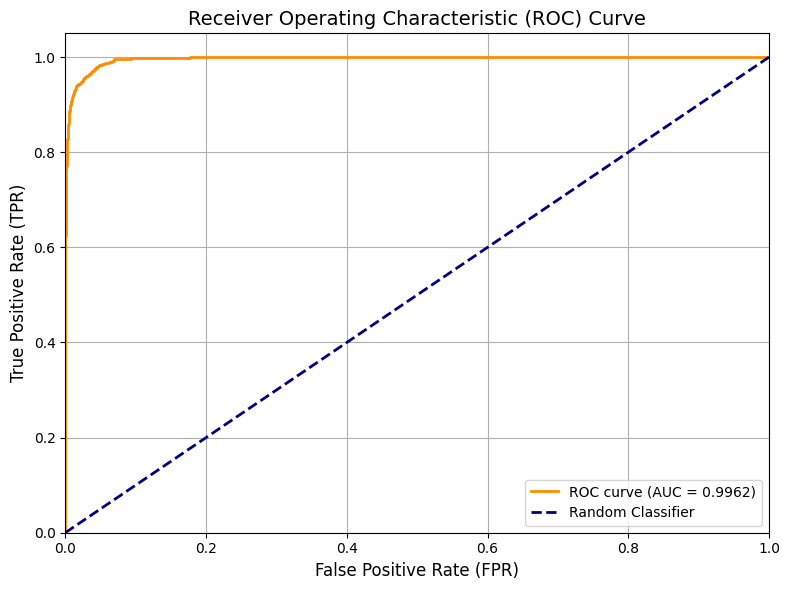

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score # Import roc_auc_score
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses

# Set random seeds for reproducibility across runs
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Check and configure GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available, using CPU.")


# ---------------------------
# Utility Functions
# ---------------------------
def print_metrics(prefix, y_true, y_pred):
    """
    Prints a set of common classification metrics.

    Args:
        prefix (str): A string to prepend to the output for identification.
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
    """
    print(f"\n{prefix}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1       :", f1_score(y_true, y_pred, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

def tune_threshold_for_pr(y_true, y_scores, min_p=0.90, min_r=0.90):
    """
    Tunes a classification threshold based on precision-recall curve.
    Prioritizes a threshold that achieves best precision and recall.
    If not possible, it returns the threshold that yields the best F1-score.

    Args:
        y_true (array-like): True binary labels.
        y_scores (array-like): Target scores (e.g., probabilities) of the positive class.
        min_p (float): Minimum desired precision.
        min_r (float): Minimum desired recall.

    Returns:
        tuple: (threshold, precision, recall, f1-score)
    """
    prec, rec, th = precision_recall_curve(y_true, y_scores)
    best = {"f1": -1, "t": 0.5, "p": 0.0, "r": 0.0}
    # Note: precision_recall_curve returns len(th)+1 points; align by appending 1.0 to thresholds
    for P, R, T in zip(prec, rec, np.append(th, 1.0)):
        f1 = 0.0 if (P + R) == 0 else 2 * P * R / (P + R)
        if f1 > best["f1"]:
            best = {"f1": f1, "t": T, "p": P, "r": R}
        # If both precision and recall criteria are met, return this threshold
        if P >= min_p and R >= min_r:
            return T, P, R, f1
    # If no threshold meets both min_p and min_r, return the one with the best F1
    return best["t"], best["p"], best["r"], best["f1"]

# Fast GAN for oversampling (Generative Adversarial Network)
def build_generator(latent_dim, out_dim):
    """
    Builds the generator model for the GAN.
    It maps random noise (latent space) to synthetic data points.

    Args:
        latent_dim (int): Dimension of the input noise vector.
        out_dim (int): Dimension of the output synthetic data.

    Returns:
        tf.keras.Model: The generator model.
    """
    inp = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(inp)  # First hidden layer
    x = layers.Dense(64, activation='relu')(x)  # Second hidden layer
    out = layers.Dense(out_dim, activation='linear')(x)  # Output layer, linear activation for generating real-valued features
    return Model(inp, out, name="generator")

def build_discriminator(in_dim):
    """
    Builds the discriminator model for the GAN.
    It tries to distinguish between real and fake data.

    Args:
        in_dim (int): Dimension of the input data (real or synthetic).

    Returns:
        tf.keras.Model: The discriminator model.
    """
    inp = layers.Input(shape=(in_dim,))
    x = layers.Dense(64, activation='relu')(inp)  # First hidden layer
    x = layers.Dense(32, activation='relu')(x)  # Second hidden layer
    out = layers.Dense(1, activation='sigmoid')(x)  # Output layer, sigmoid for binary classification (real/fake)
    return Model(inp, out, name="discriminator")

def train_gan_for_oversampling(X_minority, feature_dim, epochs=10, batch_size=512, latent_dim=16):
    """
    Trains a GAN to generate synthetic samples of the minority class.

    Args:
        X_minority (np.ndarray): Features of the minority class samples.
        feature_dim (int): Number of features in the dataset.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        latent_dim (int): Dimension of the latent space for the generator.

    Returns:
        tf.keras.Model: The trained generator model.
    """
    gen = build_generator(latent_dim, feature_dim)
    disc = build_discriminator(feature_dim)

    # Compile the discriminator (it learns to classify real vs. fake)
    disc.compile(optimizer=optimizers.Adam(1e-4), loss=losses.BinaryCrossentropy())

    # For the combined GAN model, the discriminator is frozen (not trainable)
    # when training the generator, so the generator learns to fool a fixed discriminator.
    disc.trainable = False
    z = layers.Input((latent_dim,))
    fake = gen(z)
    valid = disc(fake)
    gan = Model(z, valid)
    # Compile the combined GAN model (generator and frozen discriminator)
    gan.compile(optimizer=optimizers.Adam(1e-4), loss=losses.BinaryCrossentropy())

    n = X_minority.shape[0]
    half_bs = batch_size // 2
    steps = max(1, n // half_bs) # Number of steps per epoch

    for _ in range(epochs):
        for _ in range(steps):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random batch of real minority samples
            idx = np.random.randint(0, n, size=half_bs)
            real = X_minority[idx]
            # Generate a batch of fake samples
            z_noise = np.random.normal(size=(half_bs, latent_dim))
            fake_data = gen.predict(z_noise, verbose=0)

            # Train the discriminator on real samples (label 1)
            disc.trainable = True # Make sure discriminator is trainable during its training phase
            disc.train_on_batch(real, np.ones((half_bs, 1)))
            # Train the discriminator on fake samples (label 0)
            disc.train_on_batch(fake_data, np.zeros((half_bs, 1)))

            # ---------------------
            #  Train Generator
            # ---------------------
            # Generate noise for the generator to create fake samples
            z_noise = np.random.normal(size=(batch_size, latent_dim))
            # When training the generator, the discriminator is frozen (trainable=False)
            disc.trainable = False
            # Train the GAN (which means training the generator) to make the discriminator
            # classify the generated samples as real (label 1)
            gan.train_on_batch(z_noise, np.ones((batch_size, 1)))
    return gen

def generate_synthetic(gen, n_samples, latent_dim=16):
    """
    Generates synthetic samples using the trained generator.

    Args:
        gen (tf.keras.Model): The trained generator model.
        n_samples (int): Number of synthetic samples to generate.
        latent_dim (int): Dimension of the latent space used by the generator.

    Returns:
        np.ndarray: Generated synthetic samples.
    """
    z_noise = np.random.normal(size=(n_samples, latent_dim))
    return gen.predict(z_noise, verbose=0)

def predict_fraud_from_input(input_dict, pca, scaler, imputer, mlp_model):
    """
    Predicts fraud based on a raw input dictionary.

    Args:
        input_dict (dict): Raw input in dictionary form.
        pca (PCA): Fitted PCA transformer.
        scaler (StandardScaler): Fitted scaler.
        imputer (SimpleImputer): Fitted imputer.
        mlp_model (MLPClassifier): Trained MLP model.

    Returns:
        int: 1 for fraud, 0 for not fraud.
    """
    df_input = pd.DataFrame([input_dict])

    # Same categorical label encoding as training
    for c in ['customer','age','gender','zipcodeOri','merchant','zipMerchant','category']:
        df_input[c] = LabelEncoder().fit_transform(df_input[c])

    # Convert to array
    X_input = df_input.values

    # Impute, scale, and apply PCA
    X_input = imputer.transform(X_input)
    X_input = scaler.transform(X_input)
    X_input = pca.transform(X_input)

    # Predict
    pred = mlp_model.predict(X_input)
    return int(pred[0])


# ---------------------------
# Main Execution Function
# ---------------------------
def main(
    data_path="dataset.csv",
    pca_components=8,
    gan_epochs=10,             # Number of epochs for GAN training (set to a fast value)
    gan_latent_dim=16,         # Dimension of the latent space for GAN
    contamination=0.01,        # Expected proportion of outliers in the data for Isolation Forest
    ensemble_weight=0.7        # Weight for GAN+MLP model in the final ensemble (0.7 means 70% GAN+MLP, 30% Iso+XGB)
):
    # ---- Load & preprocess data ----
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print("Data loaded. Head of the dataset:")
    print(df.head()) # Display the first 5 rows of the loaded dataframe

    # Clean up object (string) columns by removing single quotes
    for c in df.select_dtypes(include='object').columns:
        df[c] = df[c].str.replace("'", "")

    # Apply Label Encoding to categorical features
    print("Applying Label Encoding to categorical features...")
    for c in ['customer','age','gender','zipcodeOri','merchant','zipMerchant','category']:
        # LabelEncoder converts categorical text data into numerical labels
        df[c] = LabelEncoder().fit_transform(df[c])

    # Separate features (X) and target variable (y)
    X = df.drop(columns=['fraud']).values  # Features are all columns except 'fraud'
    y = df['fraud'].values                 # 'fraud' is the target variable

    # Impute missing values using the mean
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Standardize numerical features
    print("Standardizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed) # Standardize after imputation

    # Apply Principal Component Analysis (PCA) for dimensionality reduction
    print(f"Applying PCA with {pca_components} components...")
    pca = PCA(n_components=pca_components, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled) # PCA transforms data to a lower-dimensional space

    # Split data into training and testing sets
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    feature_dim = X_train.shape[1] # Number of features after PCA

    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    print(f"Fraudulent cases in training set: {np.sum(y_train == 1)}")
    print(f"Non-fraudulent cases in training set: {np.sum(y_train == 0)}")
    print(f"Fraudulent cases in test set: {np.sum(y_test == 1)}")
    print(f"Non-fraudulent cases in test set: {np.sum(y_test == 0)}")

    # ---- Model 6: GAN oversampling + MLP (no GridSearch) ----
    print("\n--- Training GAN-based oversampling + MLP Model (Model 6) ---")
    X_min = X_train[y_train == 1] # Minority class (fraudulent transactions)
    X_maj = X_train[y_train == 0] # Majority class (non-fraudulent transactions)

    # Train the Generative Adversarial Network (GAN) using the minority class data
    gen = train_gan_for_oversampling(
        X_minority=X_min,
        feature_dim=feature_dim,
        epochs=gan_epochs,
        batch_size=512,
        latent_dim=gan_latent_dim
    )
    print("GAN training complete.")

    # Calculate how many synthetic samples are needed to balance the dataset
    n_to_generate = max(0, len(X_maj) - len(X_min))
    # Generate synthetic minority samples
    X_syn = generate_synthetic(gen, n_to_generate, gan_latent_dim)
    y_syn = np.ones(n_to_generate, dtype=int) # Assign label 1 (fraud) to synthetic samples

    # Combine original training data with synthetic samples
    X_bal = np.vstack([X_train, X_syn])
    y_bal = np.concatenate([y_train, y_syn])
    print(f"Dataset balanced. New training set shape: {X_bal.shape}")

    # Train a Multi-layer Perceptron (MLP) classifier on the balanced data
    mlp = MLPClassifier(
        hidden_layer_sizes=(64, 32), # Two hidden layers with 64 and 32 neurons
        alpha=1e-4,                  # L2 penalty (regularization term) parameter
        learning_rate_init=1e-3,     # Initial learning rate for the Adam optimizer
        max_iter=150,                # Maximum number of iterations for the solver
        random_state=RANDOM_STATE
    )
    mlp.fit(X_bal, y_bal)
    # Get probability predictions for the positive class (fraud) on the test set
    y_prob_mlp = mlp.predict_proba(X_test)[:, 1]

    # Tune the threshold for MLP predictions to optimize for precision and recall
    thr_mlp, p_mlp, r_mlp, f1_mlp = tune_threshold_for_pr(y_test, y_prob_mlp, 0.90, 0.90)
    # Convert probabilities to binary predictions using the tuned threshold
    y_pred_mlp = (y_prob_mlp >= thr_mlp).astype(int)

    print("\n=== GAN+MLP (Model 6) Results ===")
    print(f"Optimal Threshold for MLP: {thr_mlp:.4f} (Precision={p_mlp:.3f}, Recall={r_mlp:.3f}, F1={f1_mlp:.3f})")
    print_metrics("GAN+MLP Metrics", y_test, y_pred_mlp)

    # ---- Model 4 (improved): Isolation Forest on normal + XGBoost ----
    print("\n--- Training Isolation Forest + XGBoost Hybrid Model (Model 4 improved) ---")
    # Train Isolation Forest on non-fraudulent (normal) transactions
    X_train_normal = X_train[y_train == 0]
    iso = IsolationForest(
        contamination=contamination, # Expected proportion of outliers in the data
        n_estimators=100,            # Number of base estimators (trees) in the ensemble
        max_samples='auto',          # Number of samples to draw from X to train each base estimator
        random_state=RANDOM_STATE
    )
    iso.fit(X_train_normal) # Isolation Forest is an unsupervised anomaly detection algorithm

    # Get anomaly scores from Isolation Forest for both training and test sets
    # Negative decision_function values indicate outliers, so we negate them for consistency
    # (higher score = more anomalous)
    iso_train_scores = -iso.decision_function(X_train).reshape(-1, 1)
    iso_test_scores  = -iso.decision_function(X_test).reshape(-1, 1)

    # Concatenate Isolation Forest scores as a new feature to the original PCA-transformed data
    X_train_hybrid = np.hstack([X_train, iso_train_scores])
    X_test_hybrid  = np.hstack([X_test,  iso_test_scores])
    print("Isolation Forest scores integrated as new features.")

    # Train an XGBoost classifier on the hybrid features
    xgb = XGBClassifier(
        n_estimators=100,            # Number of boosting rounds (trees)
        max_depth=4,                 # Maximum depth of a tree
        learning_rate=0.1,           # Step size shrinkage to prevent overfitting
        subsample=0.8,               # Subsample ratio of the training instance
        colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
        # Adjust weight of positive class to handle class imbalance
        scale_pos_weight=max(1, int((y_train==0).sum()/(y_train==1).sum())),
        random_state=RANDOM_STATE,
        eval_metric='logloss',       # Evaluation metric for validation data
        n_jobs=-1                    # Use all available CPU cores
    )
    xgb.fit(X_train_hybrid, y_train)
    # Get probability predictions for the positive class (fraud) on the hybrid test set
    y_prob_xgb = xgb.predict_proba(X_test_hybrid)[:, 1]

    # Tune the threshold for XGBoost predictions
    thr_xgb, p_xgb, r_xgb, f1_xgb = tune_threshold_for_pr(y_test, y_prob_xgb, 0.90, 0.90)
    # Convert probabilities to binary predictions
    y_pred_xgb = (y_prob_xgb >= thr_xgb).astype(int)

    print("\n=== Isolation Forest + XGBoost Hybrid (Model 4 improved) Results ===")
    print(f"Optimal Threshold for XGBoost: {thr_xgb:.4f} (Precision={p_xgb:.3f}, Recall={r_xgb:.3f}, F1={f1_xgb:.3f})")
    print_metrics("Iso+XGB Metrics", y_test, y_pred_xgb)

    # ---- Ensemble ----
    print(f"\n--- Ensembling Models (Weight: {ensemble_weight*100}% GAN+MLP, {(1-ensemble_weight)*100}% Iso+XGB) ---")
    # Combine the probabilities from both models with a weighted average
    y_prob_ens = ensemble_weight * y_prob_mlp + (1 - ensemble_weight) * y_prob_xgb
    # Tune the threshold for the ensembled probabilities
    thr_ens, p_ens, r_ens, f1_ens = tune_threshold_for_pr(y_test, y_prob_ens, 0.90, 0.90)
    # Convert ensembled probabilities to binary predictions
    y_pred_ens = (y_prob_ens >= thr_ens).astype(int)

    print("\n=== Final Ensemble Results ===")
    print(f"Optimal Threshold for Ensemble: {thr_ens:.4f} (Precision={p_ens:.3f}, Recall={r_ens:.3f}, F1={f1_ens:.3f})")
    print_metrics("Ensemble Metrics", y_test, y_pred_ens)

    # Print explained variance ratio of PCA components
    print("\nPCA explained variance ratio (proportion of variance each principal component accounts for):")
    print(pca.explained_variance_ratio_)

    # Calculate ROC curve and AUC using true labels and predicted probabilities
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_ens)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the fitted objects
    return pca, scaler, imputer, mlp


# Entry point of the script
if __name__ == "__main__":
  main()